In [1]:
import random,copy,math,time,os,csv,sys

from importlib import reload


# pandas
import pandas as pd
import scripts.data_processing as dp
import pystan

# stats 
from sklearn.neighbors import KernelDensity

# numpy/scipy stuff
import numpy as np
from scipy import optimize  # used for fitting
import scipy as sci
from scipy import stats


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,Matern,ExpSineSquared

# plotting stuff
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from matplotlib import rc

#rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('axes', titlesize=10,labelsize=15)  
#rc('text', usetex=True)

%matplotlib inline


fig_path = os.getcwd()+'/../notes' # where to save the figures to

# Load data

In [2]:
data_directory = os.getcwd() + '/../forEthan/'

In [3]:
reload(dp)
data = dp.get_data(data_directory)

NoGuidedRNA
  success!
GAA-SpCas9
  success!
GAA-Cpf1
  success!
CGG-SpCas9
  success!
NonRepeatedSequence-SpCas9
  success!
GAA-SpCas9-2
  missing data!
NonRepeatedSequence-Cpf1
  success!
CTG-SpCas9
  success!


# Let's look at the trajectories

Text(0, 0.5, 'Number of cells')

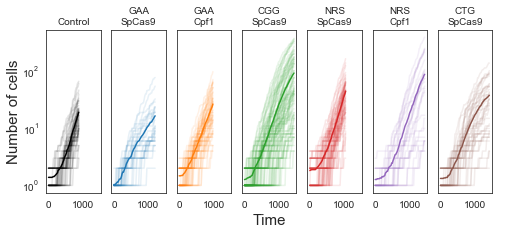

In [4]:
L = len([exp for exp in data if 't' in exp and 'AllCellsBF' in exp])
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharex=True,sharey=True)

k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 't' in exp:
        ax = axs[k]
        cells_avg = np.mean(exp['AllCellsBF'].T,axis=0)
        cells_std = np.std(exp['AllCellsBF'].T,axis=0)
        times = exp['t'][0]
        if k ==0:
            color = 'k'
        else: 
            color = 'C%i'%np.remainder(k-1,10)
            
        ax.plot(times,exp['AllCellsBF'],color = color,alpha=0.1)
        ax.semilogy(times,cells_avg,color =color)
        if 'defect' in exp:
            ax.set_title(exp['defect']+'\n'+exp['nuclease'])
        else:
            ax.set_title(exp['experiment'])
        #ax.fill_between(times,cells_avg-cells_std,cells_avg+cells_std,color = 'C%i'%np.remainder(k,10),alpha=0.1)
        k +=1


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Time')
plt.ylabel(r'Number of cells')

Text(0.5, 0, 'Time')

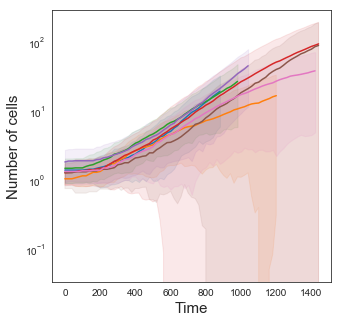

In [5]:
L = len([exp for exp in data if 't' in exp and 'AllCellsBF' in exp])
fig, ax = plt.subplots(ncols = 1,figsize=(5,5))

k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 't' in exp:
        cells_avg = np.mean(exp['AllCellsBF'].T,axis=0)
        cells_std = np.std(exp['AllCellsBF'].T,axis=0)
        times = exp['t']
        ax.semilogy(times[0],cells_avg,color = 'C%i'%np.remainder(k,10))
        ax.fill_between(times[0],cells_avg-cells_std,cells_avg+cells_std,color = 'C%i'%np.remainder(k,10),alpha=0.1)
        k+=1
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')

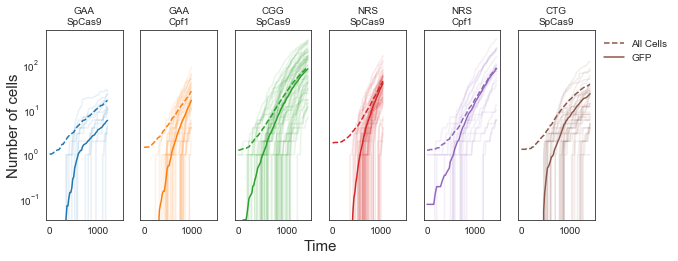

In [6]:
L = len([exp for exp in data if 't' in exp and 'AllCellsBF' in exp and 'AllCellsGFP' in exp])
fig, axs = plt.subplots(ncols = L,figsize=(10,4),sharex=True,sharey=True)

k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp:
        ax = axs[k]
        cells_avg_bf = np.mean(exp['AllCellsBF'].T,axis=0)
        cells_avg_gfp = np.mean(exp['AllCellsGFP'].T,axis=0)
        cells_std_gfp = np.std(exp['AllCellsGFP'].T,axis=0)
        times = exp['t'][0]
        
        ax.plot(times,exp['AllCellsGFP'],color = 'C%i'%np.remainder(k,10),alpha=0.1)
        ax.semilogy(times,cells_avg_bf,'--',color = 'C%i'%np.remainder(k,10),label='All Cells')
        ax.semilogy(times,cells_avg_gfp,color = 'C%i'%np.remainder(k,10),label='GFP')
        
        if 'defect' in exp:
            ax.set_title(exp['defect']+'\n'+exp['nuclease'])
        else:
            ax.set_title(exp['experiment'])
            
        k +=1

axs[-1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,frameon=False)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Time')
plt.ylabel(r'Number of cells')
plt.tight_layout()
plt.savefig("./traces.pdf")

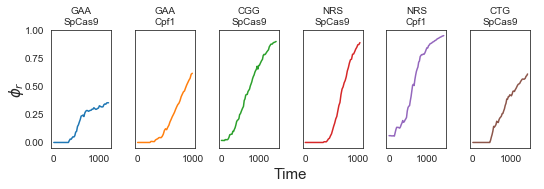

In [7]:
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharey=True)
fits = []
k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp:
        ax = axs[k]
        cells_avg_bf = np.mean(exp['AllCellsBF'].T,axis=0)
        cells_avg_gfp = np.mean(exp['AllCellsGFP'].T,axis=0)
        cells_std_gfp = np.std(exp['AllCellsGFP'].T,axis=0)
        times = exp['t'][0]
        lnphi = cells_avg_gfp/cells_avg_bf
       
        #fits.append([popt[0],pcov[0,0]])
        #print(popt)
        ax.plot(times,lnphi,'-',color = 'C%i'%np.remainder(k,10))
        ax.set_title(exp['experiment'])
        
        if 'defect' in exp:
            ax.set_title(exp['defect']+'\n'+exp['nuclease'])
        else:
            ax.set_title(exp['experiment'])
        k +=1


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Time')
plt.ylabel(r'$\phi_r$')
plt.tight_layout()
plt.savefig("./traces_phir.pdf")

## Estimate growth rates

[0.00210979 0.275127  ]
[ 0.0036441  -0.28685719]
[ 0.00387108 -0.6089724 ]
[ 0.00424712 -0.71913152]
[ 0.00409262 -1.19827967]
[ 0.00302247 -0.18238593]


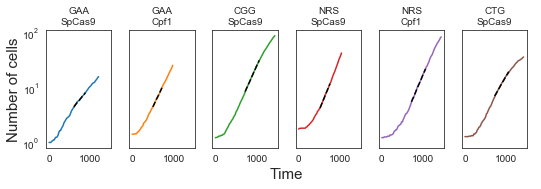

In [8]:
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharex=True,sharey=True)

k = 0
fits = []
for exp in data: 
    if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp:
        ax = axs[k]
        cells_avg = np.mean(exp['AllCellsBF'].T,axis=0)
        cells_std = np.std(exp['AllCellsBF'].T,axis=0)
        times = exp['t'][0]
        ax.semilogy(times,cells_avg,color = 'C%i'%np.remainder(k,10))
        #ax.fill_between(times,cells_avg-cells_std,cells_avg+cells_std,color = 'C%i'%np.remainder(k,10),alpha=0.1)
        
        def func(t, a,b):
            return a*t+b
        times_middle = times[int(2*len(times)//4):int(3*len(times)//4)]
        cells_middle = cells_avg[int(2*len(times)//4):int(3*len(times)//4)]
        popt, pcov = optimize.curve_fit(func, times_middle, np.log(cells_middle))
        ax.plot(times_middle,np.exp(popt[1])*np.exp(popt[0]*times_middle),'k--')
        
        if 'defect' in exp:
            ax.set_title(exp['defect']+'\n'+exp['nuclease'])
        else:
            ax.set_title(exp['experiment'])
            
        print(popt)
        fits.append([popt[0],pcov[0,0]])
        
        
        k +=1


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Time')
plt.ylabel(r'Number of cells')
plt.tight_layout()
plt.savefig("./traces_all_cells.pdf")

In [9]:
alpha_fit = np.array(fits)[:,0]

## Estimate break rates from fraction of GFP cells

## Niave fitting

[-0.00024576 -0.13806002]
[-0.00196187  0.99337994]
[-0.00263404  1.42681781]
[-0.00467769  2.68926234]
[-0.00286885  1.03379019]
[-0.00085544  0.28640911]


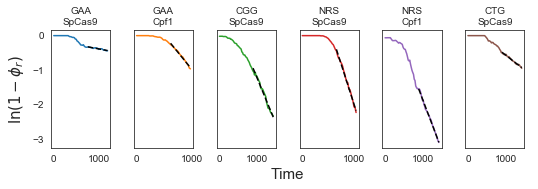

In [15]:
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharey=True)
fits = []
k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp:
        ax = axs[k]
        cells_avg_bf = np.mean(exp['AllCellsBF'].T,axis=0)
        cells_avg_gfp = np.mean(exp['AllCellsGFP'].T,axis=0)
        cells_std_gfp = np.std(exp['AllCellsGFP'].T,axis=0)
        times = exp['t'][0]
        lnphi = np.log(1-cells_avg_gfp/cells_avg_bf)
        
        
        def func(t, a,b):
            return a*t+b
        times_middle = times[int(2.5*len(times)//4):int(4*len(times)//4)]
        phi_middle = lnphi[int(2.5*len(times)//4):int(4*len(times)//4)]
        popt, pcov = optimize.curve_fit(func, times_middle, phi_middle)
       
        fits.append([popt[0],pcov[0,0]])
        print(popt)
        ax.plot(times,lnphi,'-',color = 'C%i'%np.remainder(k,10))
        ax.plot(times_middle,popt[0]*times_middle+popt[1],'k--')
        
        if 'defect' in exp:
            ax.set_title(exp['defect']+'\n'+exp['nuclease'])
        else:
            ax.set_title(exp['experiment'])
            
            
        k +=1


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Time')
plt.ylabel(r'$\ln (1-\phi_r)$')
plt.tight_layout()
plt.savefig("./traces_all_phir.pdf")

In [14]:
alpha_fit

array([0.00210979, 0.0036441 , 0.00387108, 0.00424712, 0.00409262,
       0.00302247])

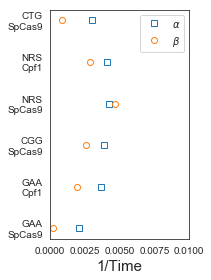

In [15]:

beta_fit = [-f[0] for f in fits]
beta_err = [f[1] for f in fits]

fig, ax = plt.subplots(figsize=(3,4))

# ax.errorbar(beta_fit,range(len(beta_fit)),xerr=np.sqrt(beta_err),\
#         linestyle='none',capsize=4,marker='o',label=r'$\beta$ [population]',fillstyle='none')
# ax.errorbar(alpha_fit,range(len(alpha_fit)),xerr=np.sqrt(alpha_err),\
#         linestyle='none',capsize=4,marker='s',fillstyle='none',label=r'$\alpha$')
ax.plot(alpha_fit,range(len(alpha_fit)),'s',\
       fillstyle='none',label=r'$\alpha$')
ax.plot(beta_fit,range(len(beta_fit)),'o',\
       label=r'$\beta$',fillstyle='none')
ax.set_xlabel(r'1/Time')
labels = [exp['defect']+'\n'+exp['nuclease'] for exp in data \
          if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp]
plt.yticks(range(len(alpha_fit)),labels)
ax.legend(frameon=True)

ax.set_xlim([0,.01])


plt.tight_layout()
plt.savefig("./fits.pdf")

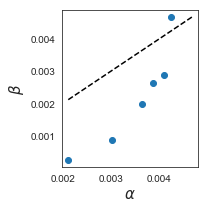

In [16]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(alpha_fit,beta_fit,'o')
x = np.linspace(np.min(alpha_fit),np.max(beta_fit),5)
ax.plot(x,x,'k--')
ax.set_ylabel(r'$\beta$')
ax.set_xlabel(r'$\alpha$')
plt.tight_layout()
plt.savefig("./fits_alpha_vs_beta.pdf")

# Estimates from single-cell dynamics

In [22]:
exp = data[1]
t = exp['t'][0]
print("Number of wells = ",len(exp['OneCellBF'].T))
for k in range(len(exp['OneCellBF'].T)):
    print('-----')
    m,r = exp['OneCellBF'].T[k],exp['OneCellGFP'].T[k]
    if np.max(r)>0:
        print(np.max(r))
        T,jump_times,jump_cells,taus,ind_gfp  = sc.get_jumps(t,m,r)
        djump_cells = jump_cells[1:]-jump_cells[:-1]
        if len(djump_cells[djump_cells>1])>0:
            print("Missing jumps at "+str(len(djump_cells[djump_cells>1]))+ " points in well " + str(k))
            print(jump_cells)
            print(djump_cells)
            print(djump_cells[djump_cells>1])

Number of wells =  27
-----
3
Missing jumps at 17 points in well 0
[ 3  4  5  7  9 11 13 17 19 23 26 27 28 32 37 40 46 47 48 57 59 67 73 77]
[1 1 2 2 2 2 4 2 4 3 1 1 4 5 3 6 1 1 9 2 8 6 4]
[2 2 2 2 4 2 4 3 4 5 3 6 9 2 8 6 4]
-----
-----
-----
5
-----
-----
-----
-----
29
Missing jumps at 4 points in well 7
[ 2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 21 22 25 26 27 28]
[1 1 1 2 1 1 1 3 1 1 2 1 1 1 1 1 3 1 1 1]
[2 3 2 3]
-----
11
-----
17
Missing jumps at 4 points in well 9
[ 2  3  5  6  7 10 11 12 14 15 18]
[1 2 1 1 3 1 1 2 1 3]
[2 3 2 3]
-----
11
Missing jumps at 1 points in well 10
[ 2  3  5  6  7  8  9 10]
[1 2 1 1 1 1 1]
[2]
-----
-----
-----
-----
-----
-----
-----
-----
-----
16
Missing jumps at 8 points in well 19
[ 2  3  4  5  6  7  8 10 11 12 13 14 15 17 20 25 27 26 28 31]
[  1   1   1   1   1   1   2   1   1   1   1   1   2   3   5   2 255   2
   3]
[  2   2   3   5   2 255   2   3]
-----
9
-----
-----
23
Missing jumps at 4 points in well 22
[ 2  3  4  5  6  7  9 10 11 12 13

In [23]:
def get_cell_cycle_times(exp):
    Tgfp = []
    Tmax = []
    for k in range(len(exp['OneCellBF'].T)):
        m,r = exp['OneCellBF'].T[k],exp['OneCellGFP'].T[k]
        if np.max(r)>0: # if there is at least one gfp cell by the end
            tgfp,jump_times,jump_cells,taus,ind_gfp  = sc.get_jumps(t,m,r)
            djump_cells = jump_cells[1:]-jump_cells[:-1]
            tmax = np.dot(taus[:-1],jump_cells)
            Tgfp.append(tgfp)
            Tmax.append(Tmax)
    return np.array(Tgfp),np.array(Tmax)

In [ ]:
d

In [ ]:
Tgfp,Tmax=  get_cell_cycle_times(data[1])

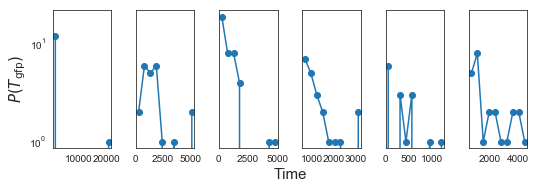

In [97]:
L = len([exp for exp in data if 't' in exp and 'AllCellsGFP' in exp])
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharey=True)

k = 0
for exp in data: 
     if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp:
        ax = axs[k]
        t = exp['t'][0]
        Ts = [ef.get_jumps(t,m,r)[0] for m,r in zip(exp['OneCellBF'].T,exp['OneCellGFP'].T) if np.max(r)>0]
       # bins = np.linspace(np.min(Ts),2000,10)
        hist,bins = np.histogram(Ts,10)
        bins = (bins[1:]+bins[:-1])/2
        ax.semilogy(bins,hist,'-o')
        k +=1
        
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Time')
plt.ylabel(r'$P(T_{\rm gfp})$')
plt.tight_layout()

In [74]:
L = len([exp for exp in data if 't' in exp and 'AllCellsBF' in exp and 'AllCellsGFP' in exp])
beta_ss = []
for exp in data: 
    if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp:
        print(len([r for m,r in zip(exp['OneCellBF'].T,exp['OneCellGFP'].T) if np.max(r)==0]) \
              /len([r for m,r in zip(exp['OneCellBF'].T,exp['OneCellGFP'].T)]))
        beta_ss.append(ef.get_single_cell_beta(exp)[0])

0.5185185185185185
0.23333333333333334
0.359375
0.12
0.25
0.13793103448275862


/Users/E/Dropbox/RESEARCH/inprogress/yeast_repair/yeast_dna_repair/estimation_functions.py:49: RuntimeWarning: overflow encountered in ubyte_scalars
  dm = m[k]-m[k-1]
/Users/E/Dropbox/RESEARCH/inprogress/yeast_repair/yeast_dna_repair/estimation_functions.py:49: RuntimeWarning: overflow encountered in ushort_scalars
  dm = m[k]-m[k-1]
/Users/E/Dropbox/RESEARCH/inprogress/yeast_repair/yeast_dna_repair/estimation_functions.py:49: RuntimeWarning: overflow encountered in ubyte_scalars
  dm = m[k]-m[k-1]
/Users/E/Dropbox/RESEARCH/inprogress/yeast_repair/yeast_dna_repair/estimation_functions.py:49: RuntimeWarning: overflow encountered in ubyte_scalars
  dm = m[k]-m[k-1]
/Users/E/Dropbox/RESEARCH/inprogress/yeast_repair/yeast_dna_repair/estimation_functions.py:49: RuntimeWarning: overflow encountered in ubyte_scalars
  dm = m[k]-m[k-1]


In [75]:
beta_ss

[0.00037377803335250144,
 0.0005855397148676171,
 0.0011269928532160528,
 0.0007857142857142857,
 0.0027573529411764703,
 0.0005249895002099958]

0.6757318799072711

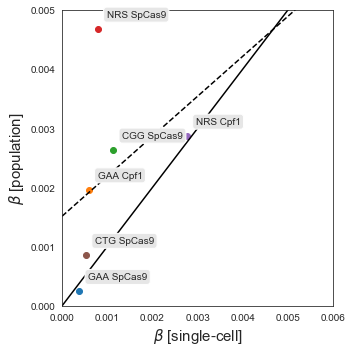

In [76]:
fig, ax = plt.subplots(figsize=(5,5))
data_used = [exp for exp in data if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp]
for exp,bs,bf in zip(data_used,beta_ss,beta_fit):
    ax.plot(bs,bf,'o')
    ax.annotate(exp['defect']+' '+exp['nuclease'], (bs+0.0002,bf+0.0002),bbox = dict(boxstyle="round", fc="0.9"))
slope, intercept, r_value, p_value, std_err = stats.linregress(beta_ss,beta_fit)
x = np.linspace(0,0.009,5)
ax.plot(x,x,'k-')
ax.plot(x,x*slope+intercept,'k--')
ax.set_ylim([0,0.005])
ax.set_xlim([0,0.006])
ax.set_ylabel(r'$\beta$ [population]')
ax.set_xlabel(r'$\beta$ [single-cell]')

plt.tight_layout()
plt.savefig("./beta_single_cell_vs_fit.pdf")
slope

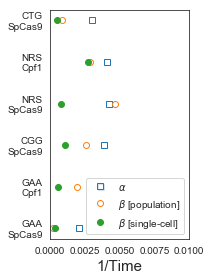

In [77]:
fig, ax = plt.subplots(figsize=(3,4))

# ax.errorbar(beta_fit,range(len(beta_fit)),xerr=np.sqrt(beta_err),\
#         linestyle='none',capsize=4,marker='o',label=r'$\beta$ [population]',fillstyle='none')
# ax.errorbar(alpha_fit,range(len(alpha_fit)),xerr=np.sqrt(alpha_err),\
#         linestyle='none',capsize=4,marker='s',fillstyle='none',label=r'$\alpha$')
ax.plot(alpha_fit,range(len(alpha_fit)),'s',\
       fillstyle='none',label=r'$\alpha$')
ax.plot(beta_fit,range(len(beta_fit)),'o',\
       label=r'$\beta$ [population]',fillstyle='none')
ax.plot(beta_ss,range(len(alpha_fit)),'o',label=r'$\beta$ [single-cell]')
#ax.set_ylabel(r'Experiment')
ax.set_xlabel(r'1/Time')
labels = [exp['defect']+'\n'+exp['nuclease'] for exp in data \
          if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp]
plt.yticks(range(len(alpha_fit)),labels)
ax.legend(frameon=True)

ax.set_xlim([0,.01])


plt.tight_layout()
plt.savefig("./fits_single_cell.pdf")

# Look at distributions of cells

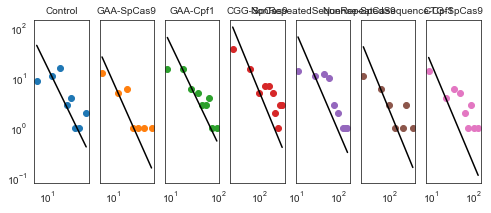

In [35]:
L = len([exp for exp in data if 't' in exp and 'AllCellsBF' in exp])
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharey=True)

k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 't' in exp:
        ax = axs[k]
        cells = exp['AllCellsBF']
        hist,bins = np.histogram(cells[-1],10)
        bins = (bins[1:]+bins[:-1])/2.
        ax.loglog(bins,hist,'o',color = 'C%i'%np.remainder(k,10))
        ax.loglog(bins,hist[1]*bins[1]**2/bins**2,'-',color = 'k')
        ax.set_title(exp['experiment'])
        n_finals = cells[-1]
        
        k +=1

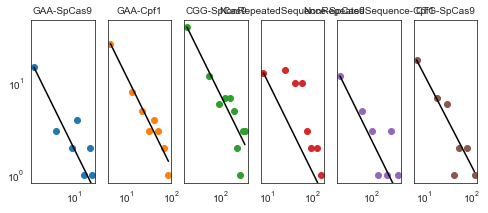

In [36]:
L = len([exp for exp in data if 't' in exp and 'AllCellsBF' in exp and 'AllCellsGFP' in exp])
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharey=True)

k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 'AllCellsGFP' in exp and 't' in exp:
        ax = axs[k]
        cells = exp['AllCellsGFP']
        hist,bins = np.histogram(cells[-1],10)
        bins = (bins[1:]+bins[:-1])/2.
        ax.loglog(bins,hist,'o',color = 'C%i'%np.remainder(k,10))
        ax.loglog(bins,hist[0]*bins[0]/bins,'-',color = 'k')
        ax.set_title(exp['experiment'])
        n_finals = cells[-1]
        
        k +=1

KeyError: 'AllCellsGFP'

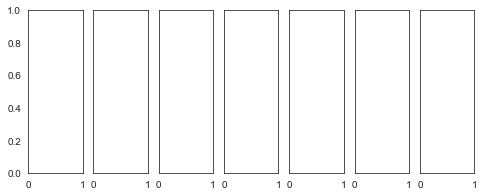

In [37]:
L = len([exp for exp in data if 't' in exp and 'AllCellsBF' in exp])
fig, axs = plt.subplots(ncols = L,figsize=(8,3),sharey=True)

k = 0
for exp in data: 
    if 'AllCellsBF' in exp and 't' in exp:
        ax = axs[k]
        fraction = exp['AllCellsGFP']/exp['AllCellsBF']
        hist,bins = np.histogram(fraction[-1],10)
        bins = (bins[1:]+bins[:-1])/2.
        ax.plot(bins,hist,'-o',color = 'C%i'%np.remainder(k,10))
       # ax.loglog(bins,hist[0]*bins[0]/bins,'-',color = 'k')
        n_finals = cells[-1]
        
        k +=1

# Look at lag time distrubtions

## First we will rescale each experiment and pool them together 

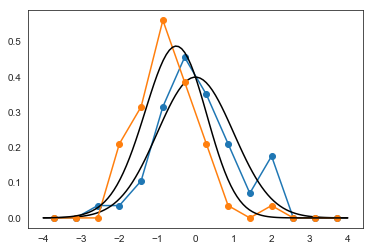

In [38]:
# verify on synthetic data

X = []
Z = []
for k in range(5):
    mean = np.random.normal(0,1)
    std = np.random.normal(1,0.2)
    x = np.random.normal(mean,std,10)
    z1 = np.random.normal(mean,std,10)
    z2 = np.random.normal(mean,std,10)
    z = np.min(np.array([z1,z2]).T,axis=1)

    x_scaled = (x-np.mean(x))/np.std(x)
    z_scaled = (z-np.mean(x))/np.std(x)
    Z = Z+ list(z_scaled)
    X = X + list(x_scaled)

xrange = np.linspace(-4,4,15)
hist, bins = np.histogram(X,xrange,density=True);
bins = (bins[1:]+bins[:-1])/2.
plt.plot(bins,hist,'-o')
xrange = np.linspace(-4,4,100)
plt.plot(xrange ,[normal_func(x,0,1) for x in xrange],'k-')

xrange = np.linspace(-4,4,15)
hist, bins = np.histogram(Z,xrange,density=True);
bins = (bins[1:]+bins[:-1])/2.
plt.plot(bins,hist,'-o')
xrange = np.linspace(-4,4,100)
plt.plot(xrange ,[normal_min_func(x,0,1) for x in xrange],'k-')


In [39]:
# collect rescaled one and two cell lag time distributions
one_cell_lntimes = []
two_cell_lntimes = []
for exp in data:
    if 'OneCellBF' in exp and 't' in exp:
        times = get_passage_times(exp['OneCellBF'],exp['t'][0],1)
        lntimes = np.log(times)
        lntimes_avg = np.mean(lntimes)
        lntimes_std = np.std(lntimes)
        lntimes = (lntimes-lntimes_avg)/lntimes_std
        one_cell_lntimes = one_cell_lntimes+list(lntimes)
        
        times = get_passage_times(exp['TwoCellBF'],exp['t'][0],2)
        lntimes = np.log(times)
        lntimes = (lntimes-lntimes_avg)/lntimes_std
        two_cell_lntimes = two_cell_lntimes+list(lntimes)
one_cell_lntimes = np.array(one_cell_lntimes)
two_cell_lntimes = np.array(two_cell_lntimes)

In [40]:
len(two_cell_lntimes)

83

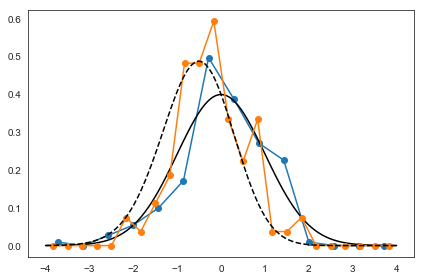

In [41]:
xrange = np.linspace(-4,4,15)
hist, bins = np.histogram(one_cell_lntimes,xrange,density=True);
bins = (bins[1:]+bins[:-1])/2.
plt.plot(bins,hist,'o-')
xrange = np.linspace(-4,4,100)
plt.plot(xrange ,[normal_func(x,0,1) for x in xrange],'k-')


xrange = np.linspace(-4,4,25)
hist, bins = np.histogram(two_cell_lntimes,xrange,density=True);
bins = (bins[1:]+bins[:-1])/2.
plt.plot(bins,hist,'o-')
xrange = np.linspace(-4,4,100)
plt.plot(xrange ,[normal_min_func(x,0,1) for x in xrange],'k--')
plt.tight_layout()
plt.savefig("./lags.pdf")

In [42]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(one_cell_lntimes[:,None])
log_dens = kde.score_samples(xrange[:,None])
plt.plot(xrange,np.exp(log_dens))
xrange = np.linspace(-4,4,100)
plt.plot(xrange ,[normal_func(x,0,1) for x in xrange],'k-')

kde = KernelDensity(kernel='gaussian', bandwidth=0.3)
kde.fit(two_cell_lntimes[:,None]
log_dens = kde.score_samples(xrange[:,None])
plt.plot(xrange,np.exp(log_dens))
xrange = np.linspace(-4,4,100)
plt.plot(xrange ,[normal_min_func(x,0,1) for x in xrange],'k--')

SyntaxError: invalid syntax (<ipython-input-42-6dd95aeeadb2>, line 10)

## Now we examine each experiments seperately

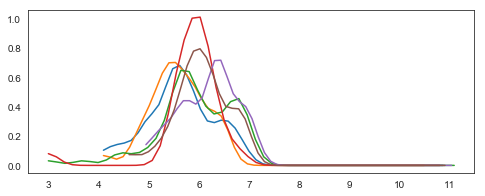

In [43]:
# collect rescaled one and two cell lag time distributions
L = len([exp for exp in data if 't' in exp and 'OneCellBF' in exp])
fig, ax = plt.subplots(ncols = 1,figsize=(8,3))
one_cell_lntimes = []
two_cell_lntimes = []
k = 0
for exp in data:
    
    
    if 'OneCellBF' in exp and 't' in exp:
        times = get_passage_times(exp['OneCellBF'],exp['t'][0],1)
        lntimes = np.log(times)
        xrange = np.linspace(min(lntimes),max(lntimes)+4,50)
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
        kde.fit(lntimes [:,None])
        log_dens = kde.score_samples(xrange[:,None])
        ax.plot(xrange,np.exp(log_dens))
        k+=1


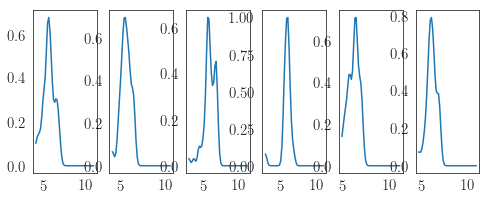

In [26]:
# collect rescaled one and two cell lag time distributions
L = len([exp for exp in data if 't' in exp and 'OneCellBF' in exp])
fig, axs = plt.subplots(ncols = L,figsize=(8,3))
one_cell_lntimes = []
two_cell_lntimes = []
k = 0
for exp in data:
    
    
    if 'OneCellBF' in exp and 't' in exp:
        ax = axs[k]
        times = get_passage_times(exp['OneCellBF'],exp['t'][0],1)
        lntimes = np.log(times)
        xrange = np.linspace(min(lntimes),max(lntimes)+4,50)
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
        kde.fit(lntimes [:,None])
        log_dens = kde.score_samples(xrange[:,None])
        ax.plot(xrange,np.exp(log_dens))
        k+=1


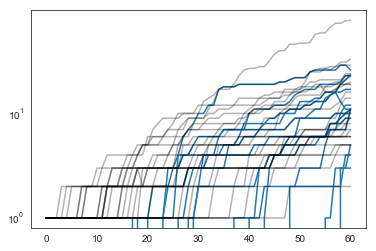

In [202]:
plt.plot(data[1]['OneCellGFP'],'C0-');
plt.semilogy(data[1]['OneCellBF'],'k-',alpha=0.3);